In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2, f_classif
from scipy import stats
import os
warnings.filterwarnings('ignore')

In [23]:
# Set up plotting configuration
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Create directories if they don't exist
os.makedirs('../processed_data', exist_ok=True)
os.makedirs('../images', exist_ok=True)

### Loading Data

In [10]:
print("\nSTEP 1: LOADING & PREPARING DATA")
print("-" * 45)

# Load the dataset
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Apply basic cleaning from previous notebooks
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print(f"Dataset loaded: {df.shape}")
print(f"Initial churn rate: {(df['Churn'] == 'Yes').mean():.1%}")

# Create a copy for preprocessing
df_processed = df.copy()


STEP 1: LOADING & PREPARING DATA
---------------------------------------------
Dataset loaded: (7043, 21)
Initial churn rate: 26.5%


### Missing Values Analysis & Treatment

In [22]:
print("\nSTEP 2: MISSING VALUES TREATMENT")
print("-" * 40)

# Analyze missing values
missing_analysis = pd.DataFrame({
    'Column': df_processed.columns,
    'Missing_Count': df_processed.isnull().sum(),
    'Missing_Percentage': (df_processed.isnull().sum() / len(df_processed) * 100).round(2)
})
missing_analysis = missing_analysis[missing_analysis['Missing_Count'] > 0]

if len(missing_analysis) > 0:
    print("Missing Values Found:")
    print(missing_analysis.to_string(index=False))
    
    # Handle TotalCharges missing values (likely new customers)
    if 'TotalCharges' in missing_analysis['Column'].values:
        print(f"\nHandling TotalCharges Missing Values:")
        
        # Analyze customers with missing TotalCharges
        missing_total_charges = df_processed[df_processed['TotalCharges'].isnull()]
        print(f"   • Customers with missing TotalCharges: {len(missing_total_charges)}")
        print(f"   • Average tenure for these customers: {missing_total_charges['tenure'].mean():.1f} months")
        print(f"   • Average monthly charges: ${missing_total_charges['MonthlyCharges'].mean():.2f}")
        
        # Strategy: For customers with 0 tenure, set TotalCharges to MonthlyCharges
        # For others, estimate based on tenure * MonthlyCharges
        mask_zero_tenure = (df_processed['TotalCharges'].isnull()) & (df_processed['tenure'] == 0)
        mask_nonzero_tenure = (df_processed['TotalCharges'].isnull()) & (df_processed['tenure'] > 0)
        
        df_processed.loc[mask_zero_tenure, 'TotalCharges'] = df_processed.loc[mask_zero_tenure, 'MonthlyCharges']
        df_processed.loc[mask_nonzero_tenure, 'TotalCharges'] = (
            df_processed.loc[mask_nonzero_tenure, 'tenure'] * 
            df_processed.loc[mask_nonzero_tenure, 'MonthlyCharges']
        )
        
        print(f"TotalCharges missing values imputed using business logic")
else:
    print("No missing values found!")



STEP 2: MISSING VALUES TREATMENT
----------------------------------------
Missing Values Found:
     Column  Missing_Count  Missing_Percentage
TenureGroup             11                0.16


### Feature Engineering

In [12]:
print("\nSTEP 3: FEATURE ENGINEERING")
print("-" * 35)

print("Creating New Features Based on Domain Knowledge:")

# 1. Customer Tenure Categories
df_processed['TenureGroup'] = pd.cut(df_processed['tenure'], 
                                   bins=[0, 12, 24, 48, 72], 
                                   labels=['0-1 Year', '1-2 Years', '2-4 Years', '4+ Years'])

# 2. Monthly Charges Categories
df_processed['ChargesGroup'] = pd.cut(df_processed['MonthlyCharges'], 
                                    bins=[0, 35, 65, 89, 120], 
                                    labels=['Low', 'Medium', 'High', 'Very High'])

# 3. Average Charges per Month (different from MonthlyCharges)
df_processed['AvgChargesPerMonth'] = df_processed['TotalCharges'] / (df_processed['tenure'] + 1)

# 4. Customer Lifetime Value (CLV) - simplified version
df_processed['CustomerLifetimeValue'] = df_processed['MonthlyCharges'] * df_processed['tenure']

# 5. Service Count - how many additional services customer has
service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 
                'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Count 'Yes' values for each customer
df_processed['TotalServices'] = 0
for col in service_cols:
    if col == 'InternetService':
        df_processed['TotalServices'] += (df_processed[col] != 'No').astype(int)
    elif col == 'MultipleLines':
        df_processed['TotalServices'] += (df_processed[col] == 'Yes').astype(int)
    else:
        df_processed['TotalServices'] += (df_processed[col] == 'Yes').astype(int)

# 6. Contract Risk Score
contract_risk = {'Month-to-month': 3, 'One year': 2, 'Two year': 1}
df_processed['ContractRisk'] = df_processed['Contract'].map(contract_risk)

# 7. Payment Method Risk Score  
payment_risk = {'Electronic check': 3, 'Mailed check': 2, 'Bank transfer (automatic)': 1, 'Credit card (automatic)': 1}
df_processed['PaymentRisk'] = df_processed['PaymentMethod'].map(payment_risk)

# 8. Senior Citizen & Family Status
df_processed['HasFamily'] = ((df_processed['Partner'] == 'Yes') | 
                           (df_processed['Dependents'] == 'Yes')).astype(int)

# 9. Internet & Phone Bundle
df_processed['HasInternetPhone'] = ((df_processed['InternetService'] != 'No') & 
                                  (df_processed['PhoneService'] == 'Yes')).astype(int)

# 10. High Value Customer Indicator
monthly_charges_75th = df_processed['MonthlyCharges'].quantile(0.75)
df_processed['HighValueCustomer'] = (df_processed['MonthlyCharges'] >= monthly_charges_75th).astype(int)

print("Created 10 new engineered features:")
new_features = ['TenureGroup', 'ChargesGroup', 'AvgChargesPerMonth', 'CustomerLifetimeValue',
                'TotalServices', 'ContractRisk', 'PaymentRisk', 'HasFamily', 
                'HasInternetPhone', 'HighValueCustomer']
for i, feature in enumerate(new_features, 1):
    print(f"   {i:2d}. {feature}")


STEP 3: FEATURE ENGINEERING
-----------------------------------
Creating New Features Based on Domain Knowledge:
Created 10 new engineered features:
    1. TenureGroup
    2. ChargesGroup
    3. AvgChargesPerMonth
    4. CustomerLifetimeValue
    5. TotalServices
    6. ContractRisk
    7. PaymentRisk
    8. HasFamily
    9. HasInternetPhone
   10. HighValueCustomer


### Feature Engineering Visualization


STEP 4: VISUALIZING NEW FEATURES
--------------------------------------


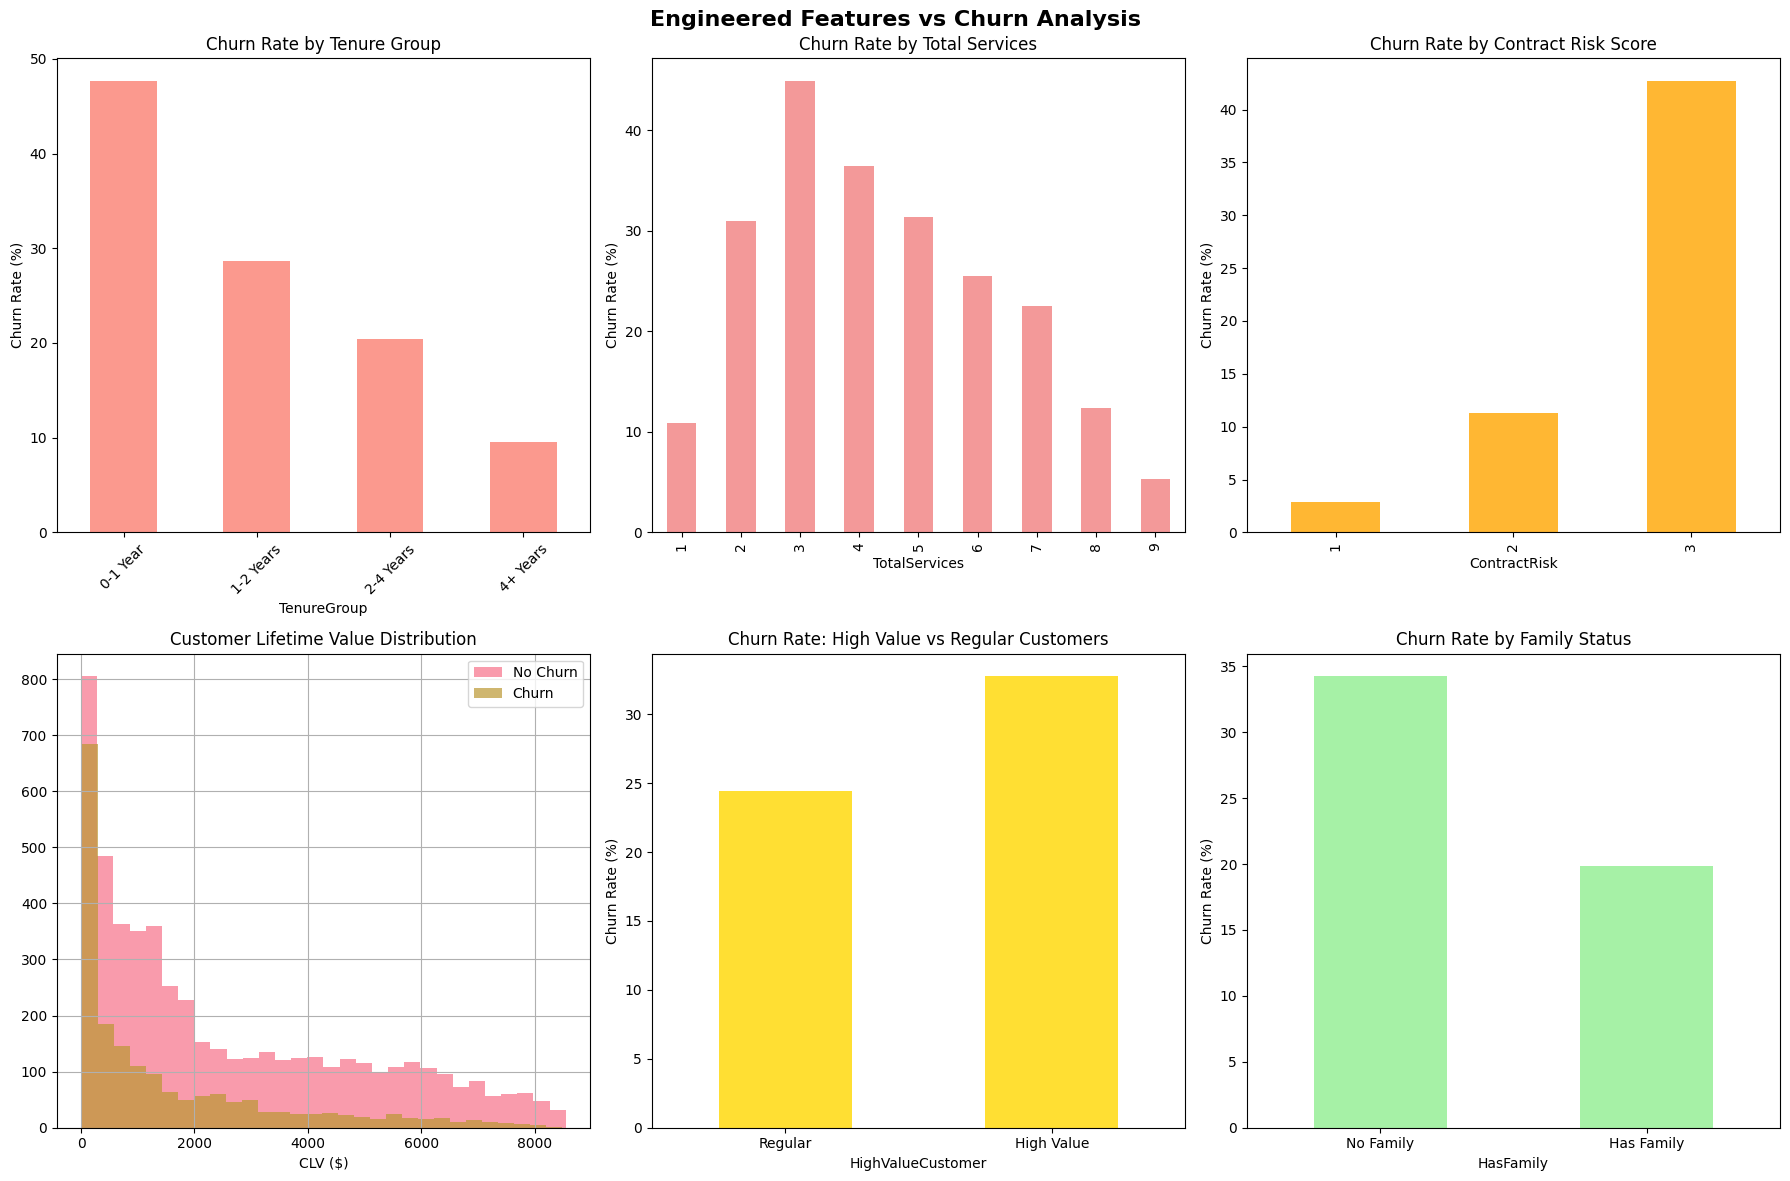

In [13]:
print("\nSTEP 4: VISUALIZING NEW FEATURES")
print("-" * 38)

# Create visualizations for new features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Engineered Features vs Churn Analysis', fontsize=16, fontweight='bold')

# 1. Tenure Groups vs Churn
tenure_churn = df_processed.groupby('TenureGroup')['Churn'].apply(lambda x: (x=='Yes').mean() * 100)
tenure_churn.plot(kind='bar', ax=axes[0,0], color='salmon', alpha=0.8)
axes[0,0].set_title('Churn Rate by Tenure Group')
axes[0,0].set_ylabel('Churn Rate (%)')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Total Services vs Churn
services_churn = df_processed.groupby('TotalServices')['Churn'].apply(lambda x: (x=='Yes').mean() * 100)
services_churn.plot(kind='bar', ax=axes[0,1], color='lightcoral', alpha=0.8)
axes[0,1].set_title('Churn Rate by Total Services')
axes[0,1].set_ylabel('Churn Rate (%)')

# 3. Contract Risk vs Churn
contract_risk_churn = df_processed.groupby('ContractRisk')['Churn'].apply(lambda x: (x=='Yes').mean() * 100)
contract_risk_churn.plot(kind='bar', ax=axes[0,2], color='orange', alpha=0.8)
axes[0,2].set_title('Churn Rate by Contract Risk Score')
axes[0,2].set_ylabel('Churn Rate (%)')

# 4. Customer Lifetime Value Distribution
df_processed[df_processed['Churn']=='No']['CustomerLifetimeValue'].hist(bins=30, alpha=0.7, 
                                                                       label='No Churn', ax=axes[1,0])
df_processed[df_processed['Churn']=='Yes']['CustomerLifetimeValue'].hist(bins=30, alpha=0.7, 
                                                                        label='Churn', ax=axes[1,0])
axes[1,0].set_title('Customer Lifetime Value Distribution')
axes[1,0].set_xlabel('CLV ($)')
axes[1,0].legend()

# 5. High Value Customer vs Churn
high_value_churn = df_processed.groupby('HighValueCustomer')['Churn'].apply(lambda x: (x=='Yes').mean() * 100)
high_value_churn.plot(kind='bar', ax=axes[1,1], color='gold', alpha=0.8)
axes[1,1].set_title('Churn Rate: High Value vs Regular Customers')
axes[1,1].set_ylabel('Churn Rate (%)')
axes[1,1].set_xticklabels(['Regular', 'High Value'], rotation=0)

# 6. Family Status vs Churn
family_churn = df_processed.groupby('HasFamily')['Churn'].apply(lambda x: (x=='Yes').mean() * 100)
family_churn.plot(kind='bar', ax=axes[1,2], color='lightgreen', alpha=0.8)
axes[1,2].set_title('Churn Rate by Family Status')
axes[1,2].set_ylabel('Churn Rate (%)')
axes[1,2].set_xticklabels(['No Family', 'Has Family'], rotation=0)

plt.tight_layout()
plt.savefig('../images/engineered_features_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### Categorical Encoding

In [14]:
print("\nSTEP 5: CATEGORICAL VARIABLE ENCODING")
print("-" * 45)

# Separate categorical and numerical columns
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('customerID')  # Remove ID column
if 'Churn' in categorical_cols:
    categorical_cols.remove('Churn')  # Handle target separately

numerical_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical columns to encode: {len(categorical_cols)}")
print(f"Numerical columns: {len(numerical_cols)}")

# Create a copy for encoding
df_encoded = df_processed.copy()

# Binary encoding for binary categorical variables
binary_cols = []
for col in categorical_cols:
    unique_vals = df_encoded[col].unique()
    if len(unique_vals) == 2:
        binary_cols.append(col)
        # Encode as 0/1
        df_encoded[col] = df_encoded[col].map({unique_vals[0]: 0, unique_vals[1]: 1})

print(f"Binary encoded columns: {binary_cols}")

# One-hot encoding for multi-class categorical variables
multi_class_cols = [col for col in categorical_cols if col not in binary_cols]
if multi_class_cols:
    print(f"One-hot encoding columns: {multi_class_cols}")
    df_encoded = pd.get_dummies(df_encoded, columns=multi_class_cols, drop_first=True)
    print(f"Dataset shape after encoding: {df_encoded.shape}")

# Encode target variable
df_encoded['Churn'] = df_encoded['Churn'].map({'No': 0, 'Yes': 1})




STEP 5: CATEGORICAL VARIABLE ENCODING
---------------------------------------------
Categorical columns to encode: 15
Numerical columns: 12
Binary encoded columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
One-hot encoding columns: ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
Dataset shape after encoding: (7043, 42)


### Feature Scaling & Normalization

In [15]:
print("\nSTEP 6: FEATURE SCALING & NORMALIZATION")
print("-" * 45)

# Identify numerical features for scaling
numerical_features_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges', 
                              'AvgChargesPerMonth', 'CustomerLifetimeValue', 'TotalServices']

print(f"Features to scale: {numerical_features_to_scale}")

# Check for outliers before scaling
print(f"\nOutlier Analysis (using IQR method):")
outlier_summary = {}
for feature in numerical_features_to_scale:
    Q1 = df_encoded[feature].quantile(0.25)
    Q3 = df_encoded[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_encoded[(df_encoded[feature] < lower_bound) | (df_encoded[feature] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(df_encoded)) * 100
    
    outlier_summary[feature] = {
        'count': outlier_count,
        'percentage': outlier_percentage
    }
    
    print(f"   • {feature}: {outlier_count} outliers ({outlier_percentage:.1f}%)")

# Apply StandardScaler (mean=0, std=1)
scaler = StandardScaler()
df_scaled = df_encoded.copy()
df_scaled[numerical_features_to_scale] = scaler.fit_transform(df_encoded[numerical_features_to_scale])

print(f"Applied StandardScaler to numerical features")


STEP 6: FEATURE SCALING & NORMALIZATION
---------------------------------------------
Features to scale: ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgChargesPerMonth', 'CustomerLifetimeValue', 'TotalServices']

Outlier Analysis (using IQR method):
   • tenure: 0 outliers (0.0%)
   • MonthlyCharges: 0 outliers (0.0%)
   • TotalCharges: 0 outliers (0.0%)
   • AvgChargesPerMonth: 0 outliers (0.0%)
   • CustomerLifetimeValue: 0 outliers (0.0%)
   • TotalServices: 0 outliers (0.0%)
Applied StandardScaler to numerical features


### Customer Segmentation


STEP 7: CUSTOMER SEGMENTATION
-----------------------------------


Customer Segment Analysis:
                 Customer_Count  Churn_Rate  Avg_Monthly_Charges  Avg_Tenure  Avg_Services
CustomerSegment                                                                           
High Risk                  2743        0.47                 0.03       -0.69         -0.25
New Customer               4300        0.14                -0.02        0.44          0.16


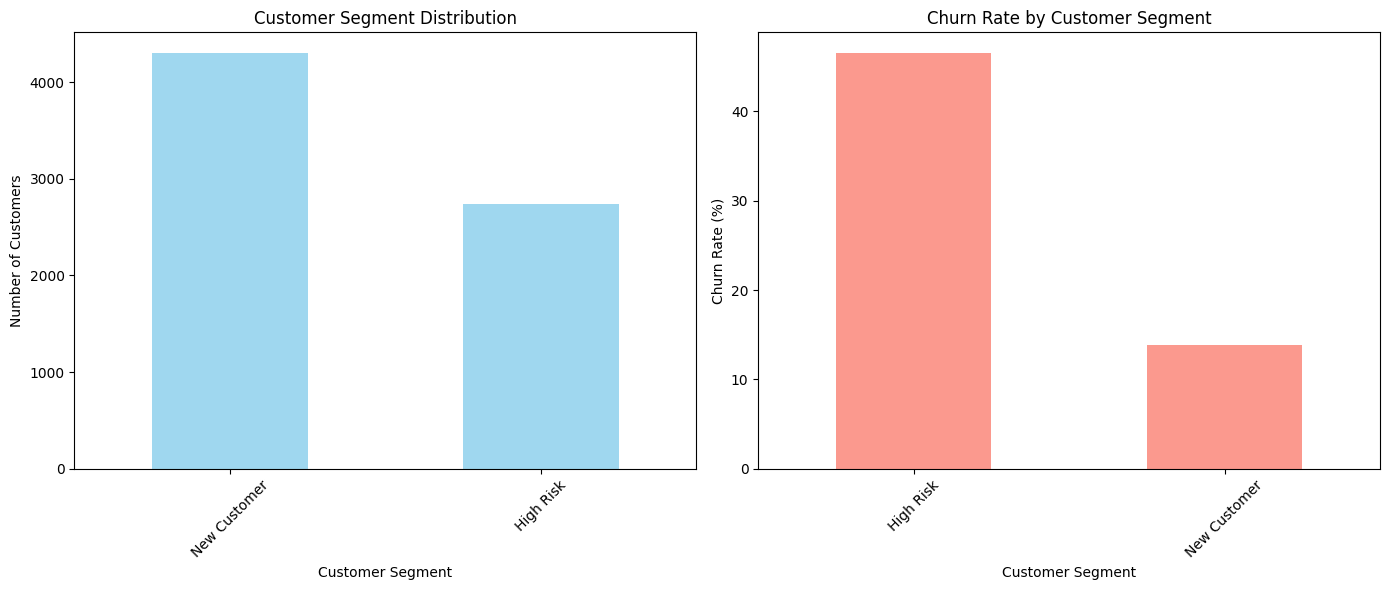

In [16]:
print("\nSTEP 7: CUSTOMER SEGMENTATION")
print("-" * 35)

# Create customer segments based on engineered features
def create_customer_segments(row):
    # High-risk segment
    if row['ContractRisk'] == 3 and row['PaymentRisk'] >= 2 and row['tenure'] <= 12:
        return 'High Risk'
    # High-value segment
    elif row['HighValueCustomer'] == 1 and row['TotalServices'] >= 4:
        return 'High Value'
    # Family segment
    elif row['HasFamily'] == 1 and row['tenure'] >= 24:
        return 'Family Loyal'
    # New customers
    elif row['tenure'] <= 6:
        return 'New Customer'
    # Long-term customers
    elif row['tenure'] >= 48:
        return 'Long Term'
    else:
        return 'Standard'

df_scaled['CustomerSegment'] = df_scaled.apply(create_customer_segments, axis=1)

# Analyze segments
segment_analysis = df_scaled.groupby('CustomerSegment').agg({
    'Churn': ['count', 'mean'],
    'MonthlyCharges': 'mean',
    'tenure': 'mean',
    'TotalServices': 'mean'
}).round(2)

segment_analysis.columns = ['Customer_Count', 'Churn_Rate', 'Avg_Monthly_Charges', 'Avg_Tenure', 'Avg_Services']
print(f"Customer Segment Analysis:")
print(segment_analysis.to_string())

# Visualize customer segments
plt.figure(figsize=(14, 6))

# Segment distribution
plt.subplot(1, 2, 1)
segment_counts = df_scaled['CustomerSegment'].value_counts()
segment_counts.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Customer Segment Distribution')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)

# Churn rate by segment
plt.subplot(1, 2, 2)
segment_churn = df_scaled.groupby('CustomerSegment')['Churn'].mean() * 100
segment_churn.plot(kind='bar', color='salmon', alpha=0.8)
plt.title('Churn Rate by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('../images/customer_segmentation.png', dpi=300, bbox_inches='tight')
plt.show()

### Feature Selection & Correlation Analysis


STEP 8: FEATURE SELECTION
--------------------------------
Column types check:
Total columns: 43
Non-numeric columns found: ['customerID', 'TenureGroup', 'ChargesGroup', 'CustomerSegment']
Numeric columns for correlation: 18
Top 15 Features Correlated with Churn:
----------------------------------------
    2. ContractRisk             : 0.397
    3. tenure                   : 0.352
    4. PaymentRisk              : 0.283
    5. HasInternetPhone         : 0.210
    6. CustomerLifetimeValue    : 0.199
    7. TotalCharges             : 0.198
    8. MonthlyCharges           : 0.193
    9. PaperlessBilling         : 0.192
   10. Dependents               : 0.164
   11. HasFamily                : 0.163
   12. SeniorCitizen            : 0.151
   13. Partner                  : 0.150
   14. HighValueCustomer        : 0.082
   15. AvgChargesPerMonth       : 0.071
   16. TotalServices            : 0.019


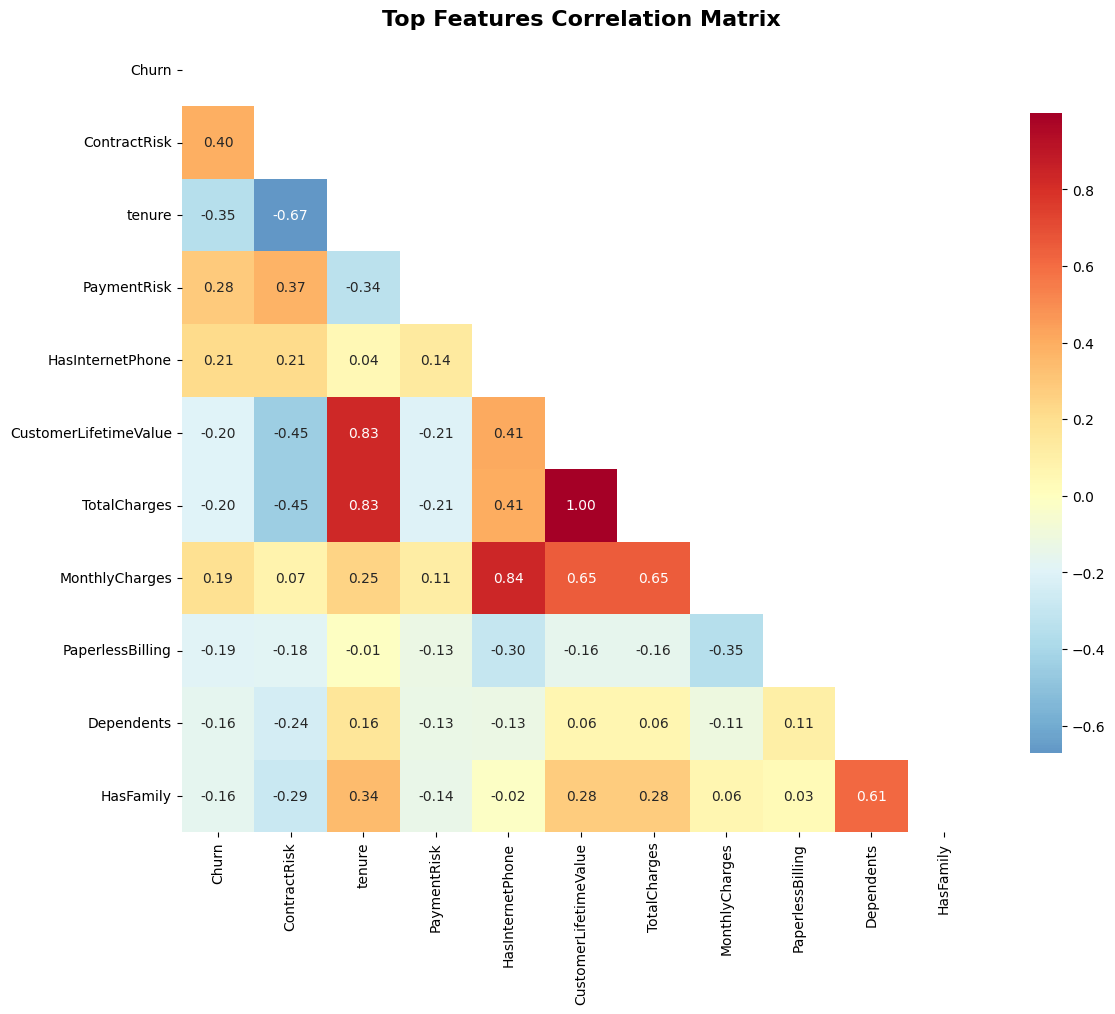

In [17]:
print("\nSTEP 8: FEATURE SELECTION")
print("-" * 32)

# First, let's check what columns we have and their types
print("Column types check:")
print(f"Total columns: {len(df_scaled.columns)}")
categorical_check = df_scaled.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Non-numeric columns found: {categorical_check}")

# Create a numeric-only dataset for correlation analysis
# Exclude categorical columns that weren't properly encoded
numeric_cols_for_corr = df_scaled.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numeric columns for correlation: {len(numeric_cols_for_corr)}")

# Calculate correlation with target using only numeric columns
df_numeric = df_scaled[numeric_cols_for_corr]
feature_correlations = df_numeric.corr()['Churn'].abs().sort_values(ascending=False)
print(f"Top 15 Features Correlated with Churn:")
print("-" * 40)
for i, (feature, corr) in enumerate(feature_correlations.head(16).items(), 1):
    if feature != 'Churn':
        print(f"   {i:2d}. {feature:<25}: {corr:.3f}")

# Create final correlation heatmap using only numeric features
plt.figure(figsize=(12, 10))
top_features = feature_correlations.head(11).index.tolist()  # Top 10 + Churn
correlation_subset = df_numeric[top_features].corr()

mask = np.triu(np.ones_like(correlation_subset, dtype=bool))
sns.heatmap(correlation_subset, mask=mask, annot=True, cmap='RdYlBu_r', 
            center=0, square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Top Features Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../images/final_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

### Model Preparation

In [18]:
print("\nSTEP 9: PREPARING FOR MODELING")
print("-" * 35)

# Prepare final dataset for modeling
# Remove non-predictive columns
columns_to_remove = ['customerID', 'TenureGroup', 'ChargesGroup']  # Categorical versions we encoded
final_features = [col for col in df_scaled.columns if col not in columns_to_remove]

# Separate features and target
X = df_scaled[final_features].drop('Churn', axis=1)
y = df_scaled['Churn']

print(f"Final Dataset for Modeling:")
print(f"   • Features (X): {X.shape}")
print(f"   • Target (y): {y.shape}")
print(f"   • Feature count: {len(X.columns)}")
print(f"   • Churn rate: {y.mean():.1%}")

# Create train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTrain-Validation Split:")
print(f"   • Training set: {X_train.shape[0]} samples")
print(f"   • Validation set: {X_val.shape[0]} samples")
print(f"   • Training churn rate: {y_train.mean():.1%}")
print(f"   • Validation churn rate: {y_val.mean():.1%}")



STEP 9: PREPARING FOR MODELING
-----------------------------------
Final Dataset for Modeling:
   • Features (X): (7043, 39)
   • Target (y): (7043,)
   • Feature count: 39
   • Churn rate: 26.5%

Train-Validation Split:
   • Training set: 5634 samples
   • Validation set: 1409 samples
   • Training churn rate: 26.5%
   • Validation churn rate: 26.5%


### Save Processed Data

In [19]:
print("\nSTEP 10: SAVING PROCESSED DATA")
print("-" * 35)

# Save the processed datasets
df_scaled.to_csv('../processed_data/processed_churn_data.csv', index=False)
X_train.to_csv('../processed_data/X_train.csv', index=False)
X_val.to_csv('../processed_data/X_val.csv', index=False)
y_train.to_csv('../processed_data/y_train.csv', index=False)
y_val.to_csv('../processed_data/y_val.csv', index=False)

# Save feature names for model interpretability
feature_names = X.columns.tolist()
with open('../processed_data/feature_names.txt', 'w') as f:
    for feature in feature_names:
        f.write(f"{feature}\n")

print(f"Saved processed datasets:")
print(f"   • processed_churn_data.csv - Full processed dataset")
print(f"   • X_train.csv, X_val.csv - Feature matrices")
print(f"   • y_train.csv, y_val.csv - Target vectors")
print(f"   • feature_names.txt - Feature list for model interpretation")




STEP 10: SAVING PROCESSED DATA
-----------------------------------
Saved processed datasets:
   • processed_churn_data.csv - Full processed dataset
   • X_train.csv, X_val.csv - Feature matrices
   • y_train.csv, y_val.csv - Target vectors
   • feature_names.txt - Feature list for model interpretation


### Summary

In [21]:
print("\nPREPROCESSING SUMMARY")
print("-" * 30)

print(f"Data Transformations Applied:")
print(f"   Missing value imputation")
print(f"   10 new engineered features created")
print(f"   Categorical encoding (binary + one-hot)")
print(f"   Feature scaling (StandardScaler)")
print(f"   Customer segmentation")
print(f"   Train-validation split")

print(f"\nFinal Dataset Characteristics:")
print(f"   • Original features: {len(df.columns)}")
print(f"   • Final features: {len(X.columns)}")
print(f"   • Feature increase: +{len(X.columns) - len(df.columns)}")
print(f"   • Data quality: High ")
print(f"   • Ready for modeling: Yes ")



PREPROCESSING SUMMARY
------------------------------
Data Transformations Applied:
   Missing value imputation
   10 new engineered features created
   Categorical encoding (binary + one-hot)
   Feature scaling (StandardScaler)
   Customer segmentation
   Train-validation split

Final Dataset Characteristics:
   • Original features: 21
   • Final features: 39
   • Feature increase: +18
   • Data quality: High 
   • Ready for modeling: Yes 
